# Binary Full Adder in Keras

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/luckykadam/adder/blob/master/full_adder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/luckykadam/adder/blob/master/full_adder.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Background

Neurons (with non-linear activation) are only capable of learning a linear decision boundary, but when sufficient units and layers of neurons work together, they can learn theoretically any complex function. This property of NNs has been mathematically proven, and demonstrated via many examples.

To understand the fundamentals of how can neural networks achieve this, it is more beneficial for a new-comer to analyse the individual parameters, and how they contribute to the final output, instead of starting with complex task like cat/dog image classification, which might be overwhelming.

Today, we will build a very simple neural network, to simlulate the binary full adder and analyse its parameters.

## Binary Adder

Binary Adder is a circuit to add two binary numbers.

### Half Adder

The Half Adder is used to add two binary bits. The half adder outputs the sum of two input bits and a carry value.

<img height="100" src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/Half_Adder.svg/360px-Half_Adder.svg.png">

### Full Adder

A Full Adder can perform an addition operation on three bits. The full adder produces a sum of three inputs and carry value. The carry value can then be used as input to the next full adder.

Using this unit in repeatition, two binary numbers of arbitrary length can be added.

<img height="180" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/Full-adder_logic_diagram.svg/800px-Full-adder_logic_diagram.svg.png">


## Logic Gates

Some logic gates which have a linear decision boundary(eg. AND, OR, NAND, NOR) can be represented using a single neuron, whereas some logic gates don't have a linear decision boundary(eg. XOR) and require multiple neurons or layers.

TODO: clarify the number of neurons required for different types of logic gates
<p>
TODO: insert images to show decision boundary of different gates

## Implementation

We are going to use Keras (`tf.keras`) to create a neural network that can simulate full adder.

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import models, layers, activations

print(tf.__version__)
np.random.seed(0)
tf.random.set_seed(0)

2.0.0


## Dataset creation

There are only 8 possible combination to inputs and ouputs. To create the dataset, we are going to repeat these unique samples.

In [3]:
n_samples = 100000//8

In [4]:
x_samples = [[0, 0, 0], [0, 1, 0], [1, 0, 0], [1, 1, 0], [0, 0, 1], [0, 1, 1], [1, 0, 1], [1, 1, 1]]
y_samples = [[0, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 1]]
x = np.array(x_samples * n_samples) # a, b, c
y = np.array(y_samples * n_samples) # c, s

sk-learn provides great functionality to split the dataset into train and test samples.

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=True)

## Model

We model the problem as classification of sum bit as active/inactive and carry bit as active/inactive.

Keras provides multiple ways to define a model.

1. `Sequential` API provides an easy interface to create a model, where data flows sequentially through a stack of layers.
2. `Model` Functional API can define complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.
3. To get even more control, Keras allows to extend `Model` class and override `__init__` and `call` functions.

In our example we don't want any feedback loop, hence `Sequencial` model would work. The layers in our network are:

1. `Input`: Inputs to the network are 3 bits: a, b and c (carry).
2. `Dense`: TODO: justify dimension of hidden layer
3. `Dense`: Outputs are 2 bits: c (next carry), s (sum).

In [6]:
model = models.Sequential(name='full_adder')
model.add(layers.Input(shape=(3,), name='input'))
model.add(layers.Dense(units=3, activation=activations.sigmoid, use_bias=False, name='hidden'))
model.add(layers.Dense(units=2, activation=activations.sigmoid, use_bias=False, name='output'))

model.summary()

Model: "full_adder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 3)                 9         
_________________________________________________________________
output (Dense)               (None, 2)                 6         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


## Loss function

Choice of loss function is a crucial step. The most common choices for different types of problems are:

1. **Regression**: Default choice is `mean_squared_error`.
2. **Classification**:
  * **Binary Classification**: Default choice is `binary_crossentropy`. The function requires that the output layer is configured with a `sigmoid` activation to limit output to (0, 1).
  * **Multi-Class Single-Label Classification**: When a sample can belong to any one class (of >2 options), default choice is `categorical_crossentropy`. This also requires a `sigmoid` activated output layer.
  * **Multi-Class Multi-Label Classification**: When a sample might belong to multiple classes (of >1 options), default choice is `binary_crossentropy`. Here each classification is considered independent of each other, and effectively multiple binary classifiers are learned at once. This also requires a `sigmoid` activated output layer.

In our Full Adder model both the outputs can be '1' at the same time, hence it would be a multi-class multi-label classification.

On choosing optimizer, `adam` works well in most cases.

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training

When training set is large, each iteration (parameter update step) might take very long. This way progress in parameters is very slow.

One trick to fasten this process is to consider small subset of train set, that fairly represents the complete train set, for each iteration. That way iterations would complete in short durations, and parameters is would be updated more frequently.

How would we create those small subset? Simplest way is to shuffle the train set and select subsets sequentially.

This trick is called **Mini-Batching**. In keras default method is mini batching, controlled by `mini_batch` parameter of `Model.fit()` method. To disable mini-batching, set `batch_size` parameter to size of train set.


In [8]:
model.fit(x_train, y_train, batch_size=16, epochs=10)
scores = model.evaluate(x_test, y_test, verbose=2)
print(scores)

Train on 90000 samples
Epoch 1/10
90000/90000 [==============================] - 6s 68us/sample - loss: 0.6317 - accuracy: 0.5472
Epoch 2/10
90000/90000 [==============================] - 6s 64us/sample - loss: 0.5264 - accuracy: 0.7500
Epoch 3/10
90000/90000 [==============================] - 5s 51us/sample - loss: 0.4600 - accuracy: 0.7458
Epoch 4/10
90000/90000 [==============================] - 5s 55us/sample - loss: 0.3907 - accuracy: 0.8262
Epoch 5/10
90000/90000 [==============================] - 5s 54us/sample - loss: 0.3198 - accuracy: 0.8007
Epoch 6/10
90000/90000 [==============================] - 5s 57us/sample - loss: 0.2660 - accuracy: 0.8350
Epoch 7/10
90000/90000 [==============================] - 5s 55us/sample - loss: 0.2234 - accuracy: 0.9144
Epoch 8/10
90000/90000 [==============================] - 6s 68us/sample - loss: 0.1906 - accuracy: 0.9628
Epoch 9/10
90000/90000 [==============================] - 6s 72us/sample - loss: 0.1653 - accuracy: 1.0000
Epoch 10/10
90

## Testing

Let's write some code to add two numbers of arbitraty length.

Generate two random numbers in range (0, 2<sup>`max_bits`-1</sup>), so that total sum is in range (0, 2<sup>`max_bits`</sup>)

In [9]:
max_bits = 8

a = np.random.randint(np.power(2, max_bits-1))
b = np.random.randint(np.power(2, max_bits-1))

a_bin = 1 * (np.flip(list(np.binary_repr(a, width=max_bits)), axis=-1) == '1')
b_bin = 1 * (np.flip(list(np.binary_repr(b, width=max_bits)), axis=-1) == '1')

print('a: {}, b: {}'.format(a, b))
print('binary representations -> a: {}, b: {}'.format(a_bin, b_bin))

a: 18, b: 39
binary representations -> a: [0 1 0 0 1 0 0 0], b: [1 1 1 0 0 1 0 0]


Now, iterate over bits of both numbers, feeding them, with carry bit, to the model. The ouput at each step is used to evaluate the corresponding bit of summed value, and update the carry bit.

In [10]:
c = 0
predictions = np.zeros(max_bits)

for i in range(max_bits):
    a_b_c = np.array([[a_bin[i], b_bin[i], c]], dtype='float32')
    c_s = model(a_b_c)[0]
    c = c_s[0]
    predictions[i] = c_s[1]

summed_bin = 1 * (predictions > 0.5)
summed = np.packbits(np.flip(summed_bin , axis=-1))[0]

print('predictions: {}'.format(predictions))
print('binary representations -> summed: {}'.format(summed_bin))
print('summed: {}'.format(summed))

predictions: [0.95964539 0.10448731 0.07424179 0.72088993 0.8321045  0.96274656
 0.23299877 0.28995553]
binary representations -> summed: [1 0 0 1 1 1 0 0]
summed: 57


## Analysis

As we can see, our model works perfectly. 

But, what has each neuron learnt? Let's analyse the weights, biases and decision boundary of each neuron.

In [11]:
hidden_layer = model.get_layer('hidden')
[hidden_weights] = hidden_layer.weights

output_layer = model.get_layer('output')
[output_weights] = output_layer.weights

### Decision Surface

Decision surface is a hypersurface that partitions the underlying vector space into two sets, one for each class. For 2-dimensional input, it reduces to a 2D curve, and is often called Decision Boundary.

Here, input is 3-dimensional, hence we get a 3D surface as decision surface.

For an individual neuron, this 3D surface, is actually a 3D plane. We are going to draw and analyse these Decision planes for each neuron.

We will be using `matplotlib` library for plotting graphs.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [13]:
def get_neuron_decision_plane(weight):
    a = weight[0] 
    b = weight[1]
    c = weight[2]
    def z_function(x, y):
        return -a*x/c + -b*y/c

    x = np.linspace(-1, 1, 3)
    y = np.linspace(-1, 1, 3)
    X, Y = np.meshgrid(x, y)
    Z = z_function(X, Y)
    length = 1 / np.sqrt(a*a + b*b + c*c)
    normal = ((0, a * length), (0, b * length), (0, c * length))
    return X, Y, Z, normal

In [14]:
def plot_decision_planes(weights, labels, title):
    n = len(weights)
    fig = plt.figure(figsize=plt.figaspect(1/n))
    fig.suptitle(title, fontsize=16, y=-0.01)
    for i in range(n):
        X, Y, Z, normal = get_neuron_decision_plane(weights[i])
        ax = fig.add_subplot(1, n, i+1, projection='3d')
        ax.plot_surface(X, Y, Z, color='green', alpha=0.5)
        ax.plot(*normal, color='red')
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.set_zlabel(labels[2])
    plt.show()

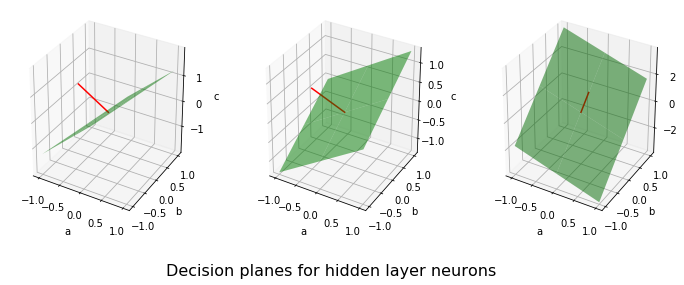

In [15]:
plot_decision_planes(tf.transpose(hidden_weights), ['a', 'b', 'c'], "Decision planes for hidden layer neurons")

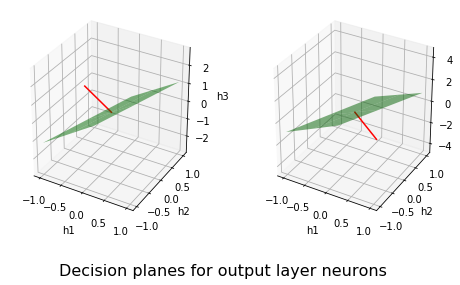

In [16]:
plot_decision_planes(tf.transpose(output_weights), ['h1', 'h2', 'h3'], "Decision planes for output layer neurons")

In [17]:
print(x_samples)
print(hidden_layer(np.array(x_samples)) > 0.5)

[[0, 0, 0], [0, 1, 0], [1, 0, 0], [1, 1, 0], [0, 0, 1], [0, 1, 1], [1, 0, 1], [1, 1, 1]]
tf.Tensor(
[[False False False]
 [ True False  True]
 [False False False]
 [False False  True]
 [ True  True False]
 [ True  True  True]
 [False  True False]
 [False False  True]], shape=(8, 3), dtype=bool)


In [18]:
print(x_samples)
print(output_layer(np.array(x_samples)) > 0.5)

[[0, 0, 0], [0, 1, 0], [1, 0, 0], [1, 1, 0], [0, 0, 1], [0, 1, 1], [1, 0, 1], [1, 1, 1]]
tf.Tensor(
[[False False]
 [ True False]
 [False  True]
 [False  True]
 [ True False]
 [ True False]
 [False  True]
 [False False]], shape=(8, 2), dtype=bool)


## Further Reading

Similar implementation of half adder can be found at: https://github.com/luckykadam/adder/blob/master/half_adder.ipynb

## References:

1. https://en.wikibooks.org/wiki/Digital_Electronics/Digital_Adder
2. https://towardsdatascience.com/neural-representation-of-logic-gates-df044ec922bc
3. https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/